# Initial Setup

In [18]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV  # For probability estimates
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import loguniform
import time
import warnings

In [2]:
file_path = '/kaggle/input/bank-campaign-portugese/phpkIxskf.arff'
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)
for column in df.columns:
    if df[column].dtype == object:
        df[column] = df[column].str.decode('utf-8')

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,Class
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown,1
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown,1
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown,1
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,1.0,-1.0,0.0,unknown,1
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5.0,may,198.0,1.0,-1.0,0.0,unknown,1


## Cleaning Data

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

class NameChanger(BaseEstimator, TransformerMixin):
    # Changing the headers with the coressponding description to make more sense.
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.rename(
            columns= {'V1':'age', 
              'V2':'job', 
              'V3':'marital',
              'V4':'education',
              'V5':'credit_default',
              'V6':'balance',
              'V7':'housing_loan',
              'V8':'personal_loan',
              'V9':'communication_type',
              'V10':'last_contact_day',
              'V11':'last_contact_month',
              'V12':'last_contact_duration',
              'V13':'number_of_contacts',
              'V14':'pdays',
              'V15':'previous_contacts',
              'V16':'previous_outcome',
              'Class':'term_deposit'}, inplace=True
        )

class Contact_Date(BaseEstimator, TransformerMixin):
    # Combining last_contact_day and last_contact_month making a new column called last_contact_date
    # While also dropping last_contact_day and last_contact month as it is assumed not needed
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['last_contact_date'] = X['last_contact_day'].astype(int).astype(str) + ' ' + X['last_contact_month'].str.capitalize()
        X['last_contact_date'] = pd.to_datetime(X['last_contact_date'], format='%d %b')
        
        # This line below is to solve the error when fitting the dataset to a Logistic Regression
        X['last_contact_date'] = X['last_contact_date'].apply(lambda x: x.toordinal())
        
        # Drop the original columns
        X.drop(['last_contact_day', 'last_contact_month'], axis=1, inplace=True)
        
        # Return the modified DataFrame
        return X
    
class Convert_Binary(BaseEstimator, TransformerMixin):
    # Applying OrdinalEncoder to any columns with the values of 'yes' or 'no'
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in X.columns:
            if set(X[col].unique()) == {'yes', 'no'}:
                enc = OrdinalEncoder(categories=[['no', 'yes']])
                X[col] = enc.fit_transform(X[[col]]).astype(int)
        return X
    
class Target_Encoder(BaseEstimator, TransformerMixin):
    # WARNING: NameChanger() must be applied first
    # Applying OrdinalEncoder to X['term_deposit'] to normalize the data
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        enc = OrdinalEncoder()
        X['term_deposit'] = enc.fit_transform(X[['term_deposit']]).astype(int)
        return X

class Floats_to_Ints(BaseEstimator, TransformerMixin):
    # Converting any columns with the dtype floats to integers
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        for col in X.columns:
            if X[col].dtype == 'float64':
                X[col] = X[col].astype(int)
        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    # WARNING: last_contact_date and Target_Encoder must be applied first
    # Applies OneHotEncoder to any columns that has dtype = object and does NOT have 'yes' or 'no values
    # While also creating a a column header name based on its unique values + original column header name
    # Then dropping the original column from the dataframe
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        ohe = OneHotEncoder()
        for col in X.columns:
            if X[col].dtype == 'object' and set(X[col].unique()) != {'yes', 'no'}:
                unique_values = X[col].unique()
                column_names = [str(value) for value in unique_values]

                matrix = ohe.fit_transform(X[[col]]).toarray()
                for i in range(len(matrix.T)):
                    X[str(col) + '_' + column_names[i]] = matrix.T[i]

                X = X.drop([col], axis=1)
        return X
    
class Reindexing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Putting term_deposit to the last column
        X['term_deposit'] = X.pop('term_deposit')
        return X

In [4]:
pipe = Pipeline([
    ("Contact_Date", Contact_Date()),
    ("Converting_yes_no", Convert_Binary()),
    ("Target_Encode", Target_Encoder()),
    ("Encoder", FeatureEncoder()),
    ("Floats_to_Ints", Floats_to_Ints()),
    ("Reindexing", Reindexing())
])

# The reason for using NameChanger seperately is because when it is applied to the pipeline
# It returns a TypeError: NoneType still don't know why and still researching as to why
NameChanger().fit_transform(df)

df = pipe.fit_transform(df)
df

,age,credit_default,balance,housing_loan,personal_loan,last_contact_duration,number_of_contacts,pdays,previous_contacts,last_contact_date,...,education_unknown,education_primary,communication_type_unknown,communication_type_cellular,communication_type_telephone,previous_outcome_unknown,previous_outcome_failure,previous_outcome_other,previous_outcome_success,term_deposit
0,58,0,2143,1,0,261,1,-1,0,693720,...,1,0,0,0,1,0,0,0,1,0
1,44,0,29,1,0,151,1,-1,0,693720,...,0,0,0,0,1,0,0,0,1,0
2,33,0,2,1,1,76,1,-1,0,693720,...,0,0,0,0,1,0,0,0,1,0
3,47,0,1506,1,0,92,1,-1,0,693720,...,0,1,0,0,1,0,0,0,1,0
4,33,0,1,0,0,198,1,-1,0,693720,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,977,3,-1,0,693916,...,1,0,1,0,0,0,0,0,1,1
45207,71,0,1729,0,0,456,2,-1,0,693916,...,0,0,1,0,0,0,0,0,1,1
45208,72,0,5715,0,0,1127,5,184,3,693916,...,0,0,1,0,0,0,0,1,0,1
45209,57,0,668,0,0,508,4,-1,0,693916,...,0,0,0,1,0,0,0,0,1,0


## Feature Understanding

### Correlation

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


<Axes: >

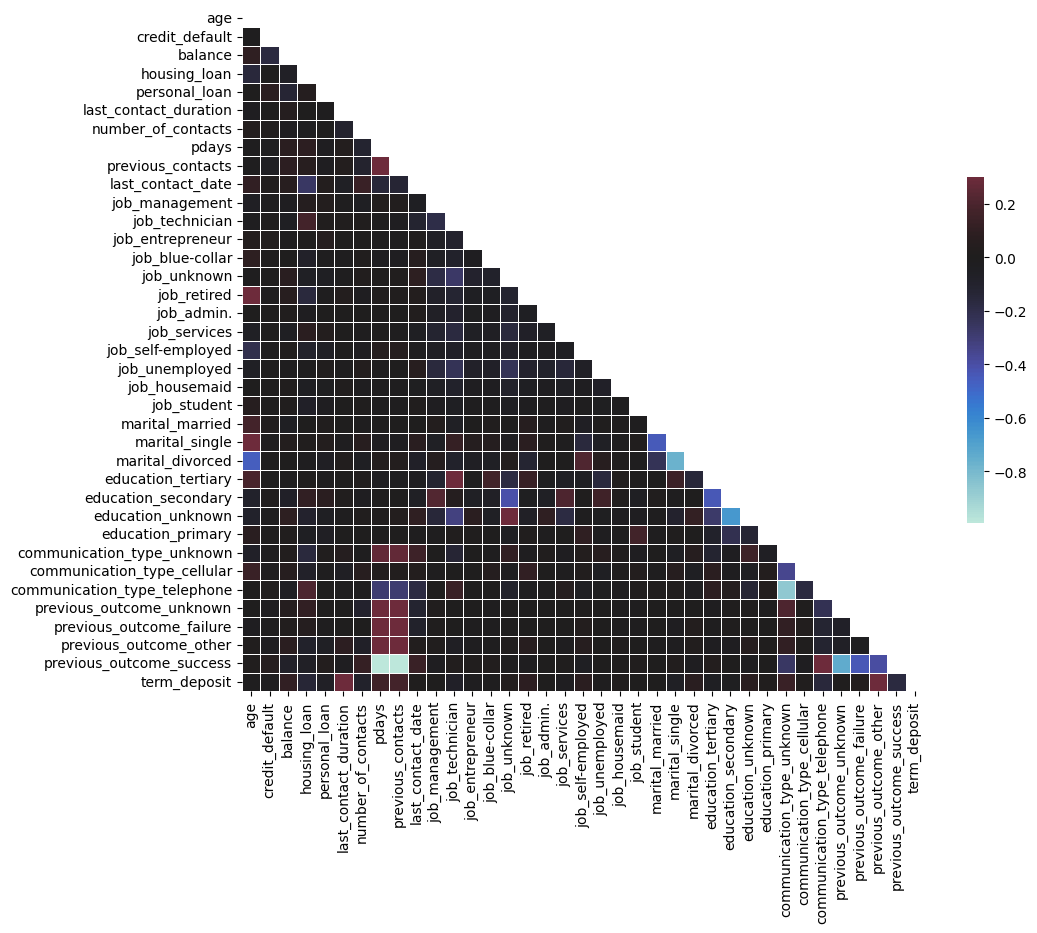

In [5]:
import seaborn as sns

corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(df.corr(method="spearman")))

fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr,
            mask=mask,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5}
               )

### Boxplots (for outliers)

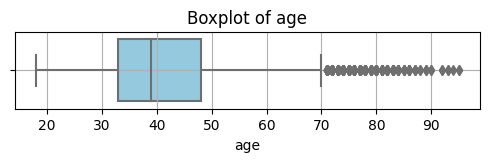

Column: age
  Min   : 18
  Median: 39.0
  Max   : 95
----------------------------------------


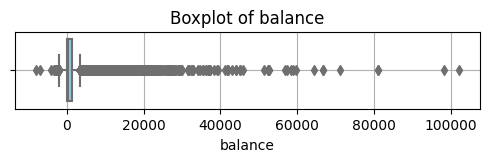

Column: balance
  Min   : -8019
  Median: 448.0
  Max   : 102127
----------------------------------------


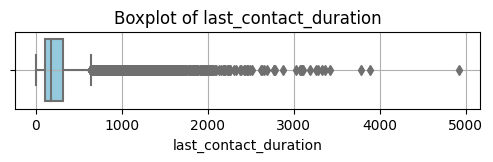

Column: last_contact_duration
  Min   : 0
  Median: 180.0
  Max   : 4918
----------------------------------------


In [11]:
box_cols = ['age', 'balance', 'last_contact_duration']

for col in box_cols:
    plt.figure(figsize=(6, 1))
    sns.boxplot(x=df[col], orient='h', color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.grid(True)
    plt.show()

    # Summary statistics
    minimum = df[col].min()
    median = df[col].median()
    maximum = df[col].max()
    print(f"Column: {col}")
    print(f"  Min   : {minimum}")
    print(f"  Median: {median}")
    print(f"  Max   : {maximum}")
    print("-" * 40)

## Model Training and Evaluation

In [7]:
features_list = [col for col in df.columns if col != 'term_deposit']
features = df[features_list]
target = df[['term_deposit']]

## Logistic Regression

In [23]:
param_distributions = {
    'penalty': ['l2'],
    'tol': [1e-3, 1e-4],
    'C': loguniform(0.01, 100),
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

random_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Running hyperparameter search...")
random_search.fit(X_train_scaled, y_train.values.ravel())
print(f"Parameter search time: {time.time() - start_time:.2f} seconds")
start_time = time.time()

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score (accuracy):", random_search.best_score_)

best_log_reg = random_search.best_estimator_

# Using StratifiedKFold just in case the data is imbalanced
skf = StratifiedKFold(n_splits=5, shuffle=True)

skf.get_n_splits(features, target)

fold = 0
aucs = []
# Loop through the splits generated by StratifiedKFold
for train_index, test_index in skf.split(features, target):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    # Initialize and fit the Logistic Regression model
    best_log_reg = LogisticRegression(max_iter=1000)
    best_log_reg.fit(X_train, y_train.values.ravel())
    
    # Getting the predictions and predict probability
    logreg_y_pred = best_log_reg.predict(X_test)
    logreg_y_pred_prob = best_log_reg.predict_proba(X_test)[:, 1]

    # Evaluate the model's accuracy
    logreg_acc_score = accuracy_score(y_test, logreg_y_pred)
    logreg_auc_score = roc_auc_score(y_test, logreg_y_pred_prob)
    
    print(f"======= Fold {fold} ========")
    print(
        f"Accuracy on the validation set is {logreg_acc_score:0.4f} and AUC is {logreg_auc_score:0.4f}"
    )
    fold += 1
    aucs.append(logreg_auc_score)

log_y_test = y_test    # For residual plot

logreg_avg_auc = np.mean(aucs)
print('\n')
print(f'Average AUC score is {logreg_avg_auc:0.4f}')

Running hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Parameter search time: 455.98 seconds
Best parameters found: {'C': 0.010672476836323726, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}
Best cross-validation score (accuracy): 0.9002903323765842
======= Fold 0 ========
Accuracy on the validation set is 0.8907 and AUC is 0.8130
======= Fold 1 ========
Accuracy on the validation set is 0.8911 and AUC is 0.8173
======= Fold 2 ========
Accuracy on the validation set is 0.8884 and AUC is 0.8239
======= Fold 3 ========
Accuracy on the validation set is 0.8911 and AUC is 0.8192
======= Fold 4 ========
Accuracy on the validation set is 0.8882 and AUC is 0.8265


Average AUC score is 0.8200


## Support Machine Vector

In [19]:
warnings.filterwarnings('ignore')

# Start timing the entire process
start_time = total_start_time = time.time()

print("Creating data splits...")
# First split: separate out final test set (80% train+val, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42
)

# Second split: create training and validation sets
# (80% train, 20% validation of the remaining data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

print(f"Data split sizes: Train={X_train.shape[0]}, Validation={X_val.shape[0]}, Test={X_test.shape[0]}")
print(f"Data preparation time: {time.time() - start_time:.2f} seconds")
start_time = time.time()

# Feature preprocessing outside the CV loop for efficiency
print("Preprocessing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(f"Feature preprocessing time: {time.time() - start_time:.2f} seconds")
start_time = time.time()

param_distributions = {
    'C': loguniform(0.01, 100),
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2'],
    'tol': loguniform(1e-5, 1e-3),
    'max_iter': [1000, 2000, 5000] 
}

print("Setting up RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=LinearSVC(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Running hyperparameter search...")
random_search.fit(X_train_scaled, y_train.values.ravel())
print(f"Parameter search time: {time.time() - start_time:.2f} seconds")
start_time = time.time()

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score (accuracy):", random_search.best_score_)

best_linear_svc = random_search.best_estimator_

# Note: LinearSVC doesn't have predict_proba by default, 
# so we'll use CalibratedClassifierCV to get probability estimates if needed for AUC
calibrated_svc = CalibratedClassifierCV(best_linear_svc, cv=3)
calibrated_svc.fit(X_train_scaled, y_train.values.ravel())
print(f"Model calibration time: {time.time() - start_time:.2f} seconds")
start_time = time.time()

val_preds = best_linear_svc.predict(X_val_scaled)
val_acc = accuracy_score(y_val, val_preds)

# For AUC, we need probabilities from the calibrated model
val_probs = calibrated_svc.predict_proba(X_val_scaled)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)

print("\nValidation Set Performance:")
print(f"Accuracy: {val_acc:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"Validation evaluation time: {time.time() - start_time:.2f} seconds")
start_time = time.time()

test_preds = best_linear_svc.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_preds)

# For AUC, use calibrated model for probabilities
test_probs = calibrated_svc.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, test_probs)

print("\nTest Set Performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"AUC: {test_auc:.4f}")
print(classification_report(y_test, test_preds))
print(f"Test evaluation time: {time.time() - start_time:.2f} seconds")

# Report total execution time
print(f"\nTotal execution time: {time.time() - total_start_time:.2f} seconds")

Creating data splits...
Data split sizes: Train=28934, Validation=7234, Test=9043
Data preparation time: 0.31 seconds
Preprocessing features...
Feature preprocessing time: 0.03 seconds
Setting up RandomizedSearchCV...
Running hyperparameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Parameter search time: 53.63 seconds
Best parameters found: {'C': 0.05415244119402541, 'loss': 'squared_hinge', 'max_iter': 2000, 'penalty': 'l2', 'tol': 0.00011207606211860574}
Best cross-validation score (accuracy): 0.8994609049861254
Model calibration time: 7.45 seconds

Validation Set Performance:
Accuracy: 0.8996
AUC: 0.8959
Validation evaluation time: 0.01 seconds

Test Set Performance:
Accuracy: 0.8985
AUC: 0.8925
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.66      0.28      0.39      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.63      0.67      9043
weighted avg       0.88      0.90      0.88      9043

Test evaluation time: 0.04 seconds

Total execution time: 61.47 seconds


### Explanation

The reason for not using SFK is because it's computionally inefficient, I decided not to use it, because I assume I have enough data to use split data without losing a significant amount of evaluation loss. But it does increase the chances of the split being 'unlucky', which can mean increase of bias or decrease/increase of variance in a single split.

# Model Comparison

## Accuracy Plot

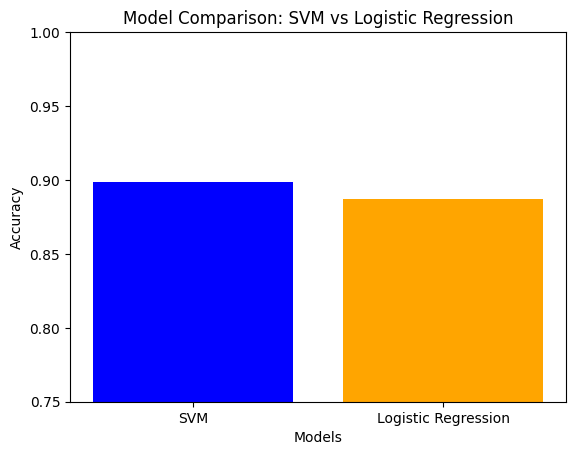

In [21]:
labels = ['SVM', 'Logistic Regression']
accuracies = [test_acc, logreg_acc_score]

plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison: SVM vs Logistic Regression')
plt.ylim(0.75, 1.0)  # Set y-axis limit from 0 to 1 for accuracy
plt.show()

# Summary

In conclusion, we found that both models are similar in it's accuracy of predicting the target. But in my opinion, in this particular case because the dataset is not updating continously, we can just use SVM for a bit more accuracy compared to Logistic Regression, but if we are going for faster computation then I would pick Logistic Regression in this case.